In [100]:
import math
import pandas as pd 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

import h3 # h3 bins from uber

In [2]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

def export_df_to_csv(df,path_file='../Inputs/train_h3.csv'):
    df.to_csv(path_file,index=False)
    print(f'file created {path_file}')
    

In [3]:
df_raw = create_crash_df()

In [4]:
df = create_temporal_features(df_raw)

In [5]:
df.head(1)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday
0,1,2018-01-01 00:25:46,-1.18885,36.931382,1,00-03,1,Jan,2018,0


In [6]:
df = assign_hex_bin(df)

In [7]:
df.head(5)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_5,h3_zone_6,h3_zone_7
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,857a6e43fffffff,867a6e417ffffff,877a6e416ffffff
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,857a4513fffffff,867a45107ffffff,877a45102ffffff
2,3,2018-01-01 02:31:49,-0.662939,37.208730,1,00-03,1,Jan,2018,0,857a4513fffffff,867a45107ffffff,877a45102ffffff
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2,03-06,1,Jan,2018,0,857a6e43fffffff,867a6e42fffffff,877a6e42cffffff
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2,03-06,1,Jan,2018,0,857a6e43fffffff,867a6e417ffffff,877a6e416ffffff


In [8]:
df_small = df.drop(["h3_zone_6", "h3_zone_7"], axis=1)

In [9]:
df_small.head(1)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_5
0,1,2018-01-01 00:25:46,-1.18885,36.931382,1,00-03,1,Jan,2018,0,857a6e43fffffff


In [10]:
df_med = df.drop(["h3_zone_5", "h3_zone_7"], axis=1)

In [11]:
df_med.head(1)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6
0,1,2018-01-01 00:25:46,-1.18885,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff


In [12]:
df_big = df.drop(["h3_zone_6", "h3_zone_5"], axis=1)

In [13]:
df_big.head(1)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_7
0,1,2018-01-01 00:25:46,-1.18885,36.931382,1,00-03,1,Jan,2018,0,877a6e416ffffff


In [14]:
df_test = pd.crosstab(df_med["h3_zone_6"], df_med["time_window_str"])

In [15]:
df_test.head()

time_window_str,00-03,03-06,06-09,09-12,12-15,15-18,18-21,21-24
h3_zone_6,,,,,,,,
867a44a6fffffff,0,0,1,0,1,0,0,0
867a44b5fffffff,0,0,1,0,0,1,0,0
867a45067ffffff,0,0,0,0,0,0,1,0
867a45077ffffff,0,0,0,0,1,0,0,0
867a45107ffffff,2,1,0,2,0,0,2,0


In [16]:
export_df_to_csv(df_test, path_file='../Inputs/test.csv')

file created ../Inputs/test.csv


In [17]:
def join_segment_files(path='../Inputs/', road_surveys='Segment_info.csv',segments_geometry='segments_geometry.geojson'):
    ''' 
        Load the survey data, Load the segment geometry, Join the two segment dfs.
        return a combined dataframe
    '''
    road_surveys = pd.read_csv(path+road_surveys)
    road_segment_locs = gpd.read_file(path+segments_geometry)
    segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
    segments_merged["longitude"] = segments_merged.geometry.centroid.x
    segments_merged["latitude"] = segments_merged.geometry.centroid.y
    segments_merged = assign_hex_bin(segments_merged)
    return segments_merged

In [18]:
segments_merged = join_segment_files()

<ipython-input-17-350d3ae77198>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["longitude"] = segments_merged.geometry.centroid.x
<ipython-input-17-350d3ae77198>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["latitude"] = segments_merged.geometry.centroid.y


In [19]:
segments_merged.columns

Index(['segment_id', 'road_name', 'geometry', 'side', '25_48', '79_76',
       '79_65', '79_39', '28_78_50', '55_90',
       ...
       '80_97_61_39_10', '80_97_61_39_11', '80_97_61_39_12', '80_97_61_39_15',
       '80_97_61_39_16', 'longitude', 'latitude', 'h3_zone_5', 'h3_zone_6',
       'h3_zone_7'],
      dtype='object', length=235)

In [20]:
segments_merged.head(1)

,segment_id,road_name,geometry,side,25_48,79_76,79_65,79_39,28_78_50,55_90,...,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16,longitude,latitude,h3_zone_5,h3_zone_6,h3_zone_7
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284...",1,1,0,4,4,0.0,5,...,1.0,0.0,0.0,0.0,0.0,36.826302,-1.284096,857a6e43fffffff,867a6e42fffffff,877a6e42cffffff


In [21]:
aggr_segments = segments_merged.drop(["segment_id", "road_name", "geometry", "side", "h3_zone_5", "h3_zone_7", 
                                      "longitude", "latitude"], axis=1)

In [22]:
aggr_segments.columns

Index(['25_48', '79_76', '79_65', '79_39', '28_78_50', '55_90', '26_76',
       '92_30', '62_51', '62_51_27',
       ...
       '80_97_61_65_12', '80_97_61_65_15', '80_97_61_65_16', '80_97_61_39_0',
       '80_97_61_39_10', '80_97_61_39_11', '80_97_61_39_12', '80_97_61_39_15',
       '80_97_61_39_16', 'h3_zone_6'],
      dtype='object', length=227)

Let's rename the columns

In [23]:
hex_names = ["h3_zone_6"]

In [24]:
new_names = []
for i in range(len(aggr_segments.columns)):
    new_names.append(i+1)
#print(new_names)

aggr_segments.columns = new_names

new_names = []
for i in range(len(aggr_segments.columns) - len(hex_names)):
    new_names.append("col_"+str(i+1))
#print(new_names)

aggr_segments.columns = [new_names + hex_names]

In [25]:
aggr_segments.iloc[5:15, 5:15]

,6,7,8,9,10,11,12,13,14,15
5,5,0,3,1,1,3,1,NaN,1,NaN
6,6,1,2,2,1,2,1,NaN,4,1.0
7,6,1,2,2,1,2,1,NaN,4,1.0
8,6,0,3,3,3,2,1,NaN,1,NaN
9,6,0,3,2,1,2,1,NaN,1,NaN
10,6,0,3,2,1,2,1,NaN,1,NaN
11,6,0,3,2,1,2,1,NaN,1,NaN
12,6,0,3,3,2,2,1,NaN,4,2.0
13,6,0,2,3,2,2,1,NaN,4,2.0
14,6,0,3,2,1,2,1,NaN,4,2.0


### Have to do some categorization of the "unknown" columns first

* First, we will attempt to identify all columns with categorical information. These should only contain the values 0 or 1. 
* Second, we will identify those columns that hold percentage data. The assumption is that they only contain values between 0 and 1 but unlike categorical columns, also have other values than 0 and 1.
* Last, we check for columns with strings. These columns would have to be removed, as we have no way of meaningfully aggregating and/or interpreting them.

For **categorical** columns, the **mode** (sum or average makes more sense?) of all values, i.e. the pre-dominant value will be used during aggregation of multiple segments into one hex-bin. Columns holding **percentage** data will be aggregated using the **average**. 

In [26]:
aggr_segments.tail().info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5 entries, 1530 to 1534
Columns: 227 entries, 1 to 227
dtypes: float64(27), int64(199), object(1)
memory usage: 8.9+ KB


In [27]:
def col_type_identifier(col_names, df):
    list_categoricals = []
    list_counts = []
    list_percentages = []
    for col in col_names:
        if (df[col].max() == 1) and (df[col].min() == 0):
            # Maybe someone has a better idea?
            if df[col].sum() % 1 == 0:
                list_categoricals.append(col)
            else:
                list_percentages.append(col)
        elif df[col].dtype == "object":
            break
        else:
            list_counts.append(col)
    
    return list_categoricals, list_counts, list_percentages


In [28]:
categoricals, counts, percentages = col_type_identifier(new_names, aggr_segments)

In [31]:
def df_split_and_merge(df, categoricals, counts, percentages):
    df_cat = df[categoricals]
    df_count = df[counts]
    df_perc = df[percentages]

    df_cat["h3_zone_6"] = segments_merged["h3_zone_6"]
    df_count["h3_zone_6"] = segments_merged["h3_zone_6"]
    df_perc["h3_zone_6"] = segments_merged["h3_zone_6"]    
    
    df_count_grouped = df_count.groupby("h3_zone_6").agg(np.sum).reset_index()
    df_cat_grouped = df_cat.groupby("h3_zone_6").agg(np.sum).reset_index()
    
    return df_count_grouped, df_cat_grouped    

In [32]:
df1, df2 = df_split_and_merge(aggr_segments, categoricals, counts, percentages)
df2

<ipython-input-31-7247fcafa9ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["h3_zone_6"] = segments_merged["h3_zone_6"]
<ipython-input-31-7247fcafa9ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count["h3_zone_6"] = segments_merged["h3_zone_6"]
<ipython-input-31-7247fcafa9ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,h3_zone_6,2,5,7,19,23,24,25,27,29,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,0,30.0,0,89,2,0.0,41,5.0,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,0,0.0,0,3,0,0.0,0,0.0,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0
2,867a6e417ffffff,0,15.0,0,42,4,0.0,24,0.0,0,...,1.0,21.0,1.0,2.0,2.0,0.0,1.0,21.0,1.0,2.0
3,867a6e427ffffff,0,14.0,0,231,45,16.0,30,0.0,4,...,57.0,105.0,29.0,15.0,57.0,15.0,57.0,103.0,29.0,15.0
4,867a6e42fffffff,1,29.0,0,466,50,22.0,55,2.0,12,...,71.0,250.0,33.0,14.0,105.0,59.0,70.0,246.0,31.0,12.0
5,867a6e437ffffff,0,0.0,0,29,15,1.0,4,0.0,1,...,22.0,19.0,12.0,9.0,14.0,1.0,22.0,19.0,12.0,9.0
6,867a6e467ffffff,8,0.0,0,13,3,3.0,8,8.0,3,...,14.0,24.0,8.0,2.0,5.0,1.0,14.0,24.0,8.0,2.0
7,867a6e477ffffff,3,0.0,0,30,3,0.0,3,0.0,5,...,4.0,39.0,1.0,0.0,6.0,0.0,4.0,39.0,1.0,0.0
8,867a6e507ffffff,0,0.0,0,2,0,0.0,1,0.0,0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
9,867a6e50fffffff,14,0.0,6,94,13,0.0,34,0.0,0,...,46.0,17.0,0.0,1.0,4.0,1.0,46.0,19.0,0.0,1.0


In [33]:
df_seg = pd.merge(df1, df2, on='h3_zone_6', how='left')

In [34]:
df_seg = df_seg.reindex(sorted(df_seg.columns), axis=1)

TypeError: '<' not supported between instances of 'int' and 'str'

In [35]:
df_seg

,h3_zone_6,1,3,4,6,8,9,10,11,12,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,174,319,319,756,274,234,113,205,125,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,18,13,13,66,13,6,6,12,6,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0
2,867a6e417ffffff,74,152,164,312,113,112,51,116,54,...,1.0,21.0,1.0,2.0,2.0,0.0,1.0,21.0,1.0,2.0
3,867a6e427ffffff,532,913,924,2434,661,449,285,600,303,...,57.0,105.0,29.0,15.0,57.0,15.0,57.0,103.0,29.0,15.0
4,867a6e42fffffff,994,1802,1781,4387,1425,1116,618,930,632,...,71.0,250.0,33.0,14.0,105.0,59.0,70.0,246.0,31.0,12.0
5,867a6e437ffffff,186,231,231,992,156,62,62,116,71,...,22.0,19.0,12.0,9.0,14.0,1.0,22.0,19.0,12.0,9.0
6,867a6e467ffffff,88,230,230,298,129,113,63,138,83,...,14.0,24.0,8.0,2.0,5.0,1.0,14.0,24.0,8.0,2.0
7,867a6e477ffffff,112,242,243,582,163,103,66,136,81,...,4.0,39.0,1.0,0.0,6.0,0.0,4.0,39.0,1.0,0.0
8,867a6e507ffffff,2,4,6,10,4,5,2,4,2,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
9,867a6e50fffffff,124,298,302,696,219,250,110,148,108,...,46.0,17.0,0.0,1.0,4.0,1.0,46.0,19.0,0.0,1.0


In [36]:
#RTA = f(zone, weather1[day], weather2[day], speed[3hours], time_cluster)

Now we need to merge the amount of crashes to the hex bins

In [37]:
df_med.head()

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff
2,3,2018-01-01 02:31:49,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2,03-06,1,Jan,2018,0,867a6e42fffffff
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2,03-06,1,Jan,2018,0,867a6e417ffffff


In [38]:
df_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   uid              6318 non-null   int64         
 1   datetime         6318 non-null   datetime64[ns]
 2   latitude         6318 non-null   float64       
 3   longitude        6318 non-null   float64       
 4   time_window      6318 non-null   int64         
 5   time_window_str  6318 non-null   object        
 6   day              6318 non-null   int64         
 7   month            6318 non-null   object        
 8   year             6318 non-null   int64         
 9   weekday          6318 non-null   int64         
 10  h3_zone_6        6318 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 543.1+ KB


## To-Do

* Regression just on weather (also add holidays as an extension)
* Regression on zones / time buckets
    * Add to segment info table x3 row for each cluster per hex bin and assign RTA's to rows (normalized on amount of time buckets per cluster)

## Assigning RTA's to time clusters and hex bins

First this will only be done for the 18 hex bins that we have the data for. The time clusters assumed are defined as follows:
* **Rush**: Weekdays from 06-09
* **Busy**: Weekdays from 09-21 and Saturday from 06-21
* **Quiet**: All other time windows (every night from 21-06 and the whole Sunday)

In [39]:
df_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   uid              6318 non-null   int64         
 1   datetime         6318 non-null   datetime64[ns]
 2   latitude         6318 non-null   float64       
 3   longitude        6318 non-null   float64       
 4   time_window      6318 non-null   int64         
 5   time_window_str  6318 non-null   object        
 6   day              6318 non-null   int64         
 7   month            6318 non-null   object        
 8   year             6318 non-null   int64         
 9   weekday          6318 non-null   int64         
 10  h3_zone_6        6318 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 543.1+ KB


**Below is the code to assign the clusters into a separate column**

In [40]:
df_med.loc[(df_med['time_window'] < 3) | (df_med['time_window'] == 8) | (df_med['weekday'] == 6), 'time_cluster'] = 'Quiet'
df_med.loc[(df_med['time_window'] > 3) & (df_med['time_window'] < 8) & (df_med['weekday'] < 6), 'time_cluster'] = 'Busy'
df_med.loc[(df_med['time_window'] == 3) & (df_med['weekday'] < 5), 'time_cluster'] = 'Rush'

In [41]:
df_med.head(10)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6,time_cluster
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff,Quiet
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff,Quiet
2,3,2018-01-01 02:31:49,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff,Quiet
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2,03-06,1,Jan,2018,0,867a6e42fffffff,Quiet
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2,03-06,1,Jan,2018,0,867a6e417ffffff,Quiet
5,6,2018-01-01 04:04:09,-0.662939,37.208730,2,03-06,1,Jan,2018,0,867a45107ffffff,Quiet
6,7,2018-01-01 05:31:17,-1.165228,36.960008,2,03-06,1,Jan,2018,0,867a6e4a7ffffff,Quiet
7,8,2018-01-01 07:57:56,-1.301303,36.820903,3,06-09,1,Jan,2018,0,867a6e557ffffff,Rush
8,9,2018-01-01 09:57:27,-1.134640,36.848220,4,09-12,1,Jan,2018,0,867a6e4f7ffffff,Busy
9,10,2018-01-01 10:48:59,-1.117207,37.008278,4,09-12,1,Jan,2018,0,867a6e4b7ffffff,Busy


**Below is the code for counting the RTA's per hex bin and time cluster**

In [42]:
df5 = df_med.groupby(["h3_zone_6", "time_cluster"]).agg({"uid": "count"}).reset_index()
df5.head(20)

,h3_zone_6,time_cluster,uid
0,867a44a6fffffff,Quiet,1
1,867a44b5fffffff,Busy,1
2,867a44b5fffffff,Rush,1
3,867a45067ffffff,Busy,1
4,867a45077ffffff,Busy,1
5,867a45107ffffff,Busy,4
6,867a45107ffffff,Quiet,3
7,867a4511fffffff,Busy,1
8,867a4512fffffff,Busy,1
9,867a45147ffffff,Busy,1


**Next, we need to create an empty table that contains all hex bins and all time cluster**

In [43]:
hex_bins = set(df["h3_zone_6"])
print("List of unique hex bins", len(hex_bins))
hex_bins_all = list(hex_bins) * 3
print("* 3 =", len(hex_bins_all))

List of unique hex bins 117
* 3 = 351


In [44]:
state_q = ["Quiet"] * len(hex_bins)
state_b = ["Busy"] * len(hex_bins)
state_r = ["Rush"] * len(hex_bins)
states = state_q + state_b + state_r
len(states)

351

In [45]:
df_empty = pd.DataFrame(data=[hex_bins_all, states]).T
df_empty.columns = ["h3_zone_6", "time_cluster"]
df_empty.head()

,h3_zone_6,time_cluster
0,867a6e45fffffff,Quiet
1,867a6e587ffffff,Quiet
2,867a6e19fffffff,Quiet
3,867a6e69fffffff,Quiet
4,867a616b7ffffff,Quiet


In [46]:
df_empty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   h3_zone_6     351 non-null    object
 1   time_cluster  351 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


**Next we are gonna "outer" merge the empty table (fill it) with our RTA's per hex bin and time cluster**

In [47]:
df_rta_clustered = pd.merge(df_empty, df5, on=['h3_zone_6', 'time_cluster'], how='outer')

In [48]:
df_rta_clustered.head()

,h3_zone_6,time_cluster,uid
0,867a6e45fffffff,Quiet,14.0
1,867a6e587ffffff,Quiet,1.0
2,867a6e19fffffff,Quiet,NaN
3,867a6e69fffffff,Quiet,1.0
4,867a616b7ffffff,Quiet,NaN


In [49]:
df_rta_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   h3_zone_6     351 non-null    object 
 1   time_cluster  351 non-null    object 
 2   uid           217 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.0+ KB


In [50]:
df_rta_clustered_filled = df_rta_clustered.fillna(0)

In [51]:
df_rta_clustered_filled.sort_values(by=["h3_zone_6", "time_cluster"]).tail(20)

,h3_zone_6,time_cluster,uid
53,867a6ec8fffffff,Quiet,6.0
287,867a6ec8fffffff,Rush,1.0
176,867a6ec97ffffff,Busy,25.0
59,867a6ec97ffffff,Quiet,15.0
293,867a6ec97ffffff,Rush,7.0
191,867a6ec9fffffff,Busy,4.0
74,867a6ec9fffffff,Quiet,4.0
308,867a6ec9fffffff,Rush,1.0
167,867a6ecf7ffffff,Busy,1.0
50,867a6ecf7ffffff,Quiet,0.0


***

### Regression on hex bins (to later sample more data from it)
Next we will filter for only those hex bins that we have segment data for (file provided by Zindi)

In [53]:
reduced_hex = list(df_seg.h3_zone_6)

In [54]:
df_reduced_segments = df_rta_clustered_filled[df_rta_clustered_filled["h3_zone_6"].isin(reduced_hex)]
df7 = df_reduced_segments.sort_values(by=["h3_zone_6", "time_cluster"])

array([[<AxesSubplot:title={'center':'uid'}>]], dtype=object)

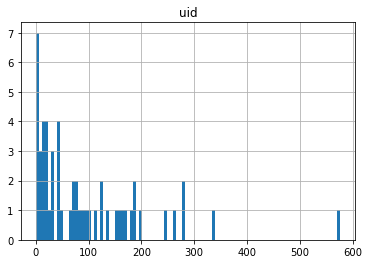

In [55]:
df7.hist(bins=100)

In [56]:
df_reduced_segments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 6 to 345
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   h3_zone_6     54 non-null     object 
 1   time_cluster  54 non-null     object 
 2   uid           54 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.7+ KB


**Joining the segment features with the outcomes per hex bin (reduced number of zones) and per time clusters**

In [57]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Columns: 227 entries, h3_zone_6 to 226
dtypes: float64(27), int64(199), object(1)
memory usage: 32.1+ KB


In [58]:
df_rta_clustered_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   h3_zone_6     351 non-null    object 
 1   time_cluster  351 non-null    object 
 2   uid           351 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.0+ KB


# Continue here!!!

To Do:
1. Need to still normalize the total RTA by amount of time windows in a cluster
2. Add 227 features to table
3. Use PCA to identify/reduce to important features

In [59]:
df7.groupby("time_cluster").uid.sum()

time_cluster
Busy     2518.0
Quiet    1282.0
Rush     1333.0
Name: uid, dtype: float64

In [60]:
list(df7.groupby("time_cluster").uid.sum())

[2518.0, 1282.0, 1333.0]

In [61]:
list_of_clusters = ["Quiet", "Busy", "Rush"]

In [108]:
rush = 5 * 1
quiet = 6 * 3 + 8
busy = 6 * 4 + 1
print("rush:", rush)
print("busy:", busy)
print("quiet:", quiet)

rush: 5
busy: 25
quiet: 26


In [109]:
cluster_dict = {"Busy": busy, "Quiet": quiet, "Rush": rush}

### 1. Normalizing RTA's for number of time windows

In [110]:
df7["RTA_n"] = 0

In [111]:
df7.head()

,h3_zone_6,time_cluster,uid,RTA_n
145,867a6e407ffffff,Busy,335.0,0
28,867a6e407ffffff,Quiet,138.0,0
262,867a6e407ffffff,Rush,200.0,0
130,867a6e40fffffff,Busy,47.0,0
13,867a6e40fffffff,Quiet,27.0,0


In [112]:
for cluster in list_of_clusters:
    df7.loc[df7["time_cluster"] == cluster, "RTA_n"] = df7["uid"] / cluster_dict.get(cluster)

In [113]:
df7.head()

,h3_zone_6,time_cluster,uid,RTA_n
145,867a6e407ffffff,Busy,335.0,13.400000
28,867a6e407ffffff,Quiet,138.0,5.307692
262,867a6e407ffffff,Rush,200.0,40.000000
130,867a6e40fffffff,Busy,47.0,1.880000
13,867a6e40fffffff,Quiet,27.0,1.038462


<AxesSubplot:>

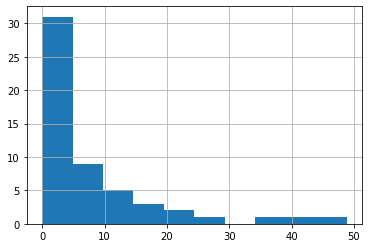

In [114]:
df7.RTA_n.hist()

### 2. Add features to table

In [115]:
df_regr = pd.merge(df7, df_seg, on='h3_zone_6', how='left')

In [116]:
list_of_n = df_regr.columns.values

In [117]:
list_of_n[2] = "RTA"

In [118]:
df_regr.columns = list_of_n

In [119]:
df_regr.head()

,h3_zone_6,time_cluster,RTA,RTA_n,1,3,4,6,8,9,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,Busy,335.0,13.400000,174,319,319,756,274,234,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e407ffffff,Quiet,138.0,5.307692,174,319,319,756,274,234,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
2,867a6e407ffffff,Rush,200.0,40.000000,174,319,319,756,274,234,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
3,867a6e40fffffff,Busy,47.0,1.880000,18,13,13,66,13,6,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0
4,867a6e40fffffff,Quiet,27.0,1.038462,18,13,13,66,13,6,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [70]:
df_regr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Columns: 230 entries, h3_zone_6 to 226
dtypes: float64(29), int64(199), object(2)
memory usage: 97.5+ KB


### 3. PCA

This analysis was done following the "Dimensionality_Reduction" module and more precisely, the notebook "1-Principal_Component_Analysis".

### 3.1 Data Scaling

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler()

In [89]:
X_num = df_regr.drop(["h3_zone_6", "time_cluster", 'RTA', "RTA_n"],axis=1)
X_cat = df_regr["time_cluster"]
y = df_regr['RTA_n']

In [90]:
X_num_t = scaler.fit_transform(X_num)

In [93]:
df_regr_scaled = pd.DataFrame(data=X_num_t,columns=X_num.columns)

In [95]:
df_regr_scaled.head(1)

,1,3,4,6,8,9,10,11,12,13,...,217,218,219,220,221,222,223,224,225,226
0,0.066956,0.074491,0.069021,0.02085,0.18766,0.257468,0.119111,0.187608,0.154253,-0.104603,...,-0.517076,0.338516,-0.364625,-0.023939,-0.412027,-0.321029,-0.608984,0.331693,-0.364929,0.0


In [96]:
df_regr_scaled.describe().round()

,1,3,4,6,8,9,10,11,12,13,...,217,218,219,220,221,222,223,224,225,226
count,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,...,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
mean,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
max,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0


### 3.2 PCA

In [97]:
from sklearn.decomposition import PCA

In [143]:
pca = PCA(n_components=0.8)

In [144]:
df_scaled_pca = pca.fit(df_regr_scaled)

**Plotting**

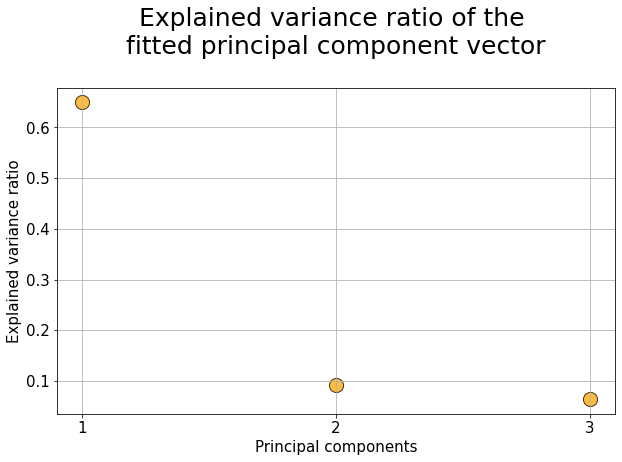

In [145]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],
            y=df_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

End.

In [146]:
i = 1
for pca_component in df_scaled_pca.explained_variance_ratio_:
    if pca_component > 0.01:
        print("Component", i, "explains", round(pca_component * 100, 2), "%")
        i += 1

Component 1 explains 64.91 %
Component 2 explains 9.21 %
Component 3 explains 6.44 %


In [147]:
df_regr_pca = pca.transform(df_regr_scaled)

In [148]:
df_regr_pca.shape

(54, 3)

***

### To Do:
**Paste together with categorical data to build data set for prediction**

**Regress!**

***

### Overlap (intersection) of hex bins of accidents and segment info

In [ ]:
aggr_segments.h3_zone_6.unique()

In [ ]:
len(set(df_med.h3_zone_6.unique()).intersection(set(aggr_segments.h3_zone_6.unique())))

In [ ]:
print(aggr_segments.columns)
print(df_med.columns)

### Need to aggregate both tables on the hex-bins first

### Then we can merge

In [ ]:
#df_segment_info = pd.merge(df_med, aggr_segments, on='h3_zone_6', how='left')

In [ ]:
#df_segment_info